# Simulation

## Initialize Map

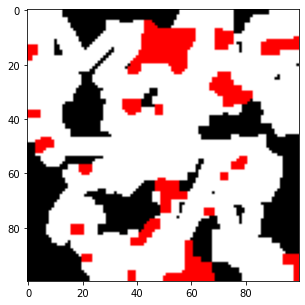

In [7]:
from swarm_mapping.map import Map
import random
random.seed(27)
m = Map(100, 100, space_fill=0.50,hazard_fill=0.25)
m.show()

## Fixed Model

Average step time: 0.013369445562362671
Completion: 0.6044198895027625, Loss: 0.38


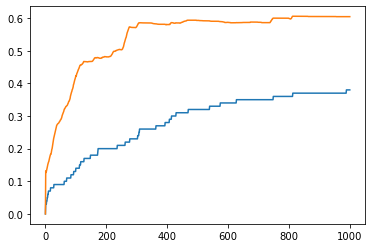

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from swarm_mapping.world import World
import time

def measure_agent_loss(world):
        dead_agents = [agent for agent in world.agents if not agent.alive]
        return len(dead_agents)/len(world.agents)

def measure_map_completion(world):
    actual = world.map.grid == 0
    mapped = world.agents_map == 0
    return np.count_nonzero(mapped) / np.count_nonzero(actual)

# Parameters
radius = 3
num_agents = 100
max_steps = 1000

t = []
completion = []
loss = []

# Start simulation
w = World(100,100, num_agents, marker_size=radius, m=m)

step = 0
start = time.time()
for i in range(max_steps):
    t.append(i)
    completion.append(measure_map_completion(w))
    loss.append(measure_agent_loss(w))
    w.step()
    if (completion[-1] >= 0.9):
        break
end = time.time()
print(f"Average step time: {(end - start)/max_steps}")
plt.plot(t, loss)
plt.plot(t, completion)
print(f"Completion: {completion[-1]}, Loss: {loss[-1]}")

## Adaptive Model

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from swarm_mapping.world import World

DCOMP_LIM = 4

class AdaptiveModel:
    def __init__(self, world, weights):
        self.world = world
        self.radius = world.marker_size
        self.weights = weights
        
        self.loss_history = []
        self.dloss_history = []
        self.avgdloss_history = []
        self.completion_history = []
        self.dcompletion_history = []
        self.avgdcompletion_history = []
        self.radius_history = []
        
    def step(self):
        # Set radius
        self.world.set_marker(int(round(self.radius)))
        
        # Step world
        self.world.step()
        
        # Calculate metrics
        loss = self.measure_agent_loss()
        if len(self.loss_history) > 0:
            dloss = loss - self.loss_history[-1]
        else: 
            dloss = 0
        self.loss_history.append(loss)
        self.dloss_history.append(dloss)
        avgdloss = np.average(self.dloss_history)
        self.avgdloss_history.append(avgdloss)
        
        comp = self.measure_map_completion()
        if len(self.completion_history) > 0:
            dcomp = comp - self.completion_history[-1]
        else:
            dcomp = 0
        self.completion_history.append(comp)
        self.dcompletion_history.append(dcomp)
        avgdcomp = np.average(self.dcompletion_history)
        self.avgdcompletion_history.append(avgdcomp)
        
        # Update radius
        self.radius = self.calc_radius()
        self.radius_history.append(self.radius)
        
    def calc_radius(self):
        w1 = self.weights[0]
        w2 = self.weights[1]
        w3 = self.weights[2]
        loss = self.loss_history[-1]
        comp = self.completion_history[-1]
        dloss = self.avgdloss_history[-1]
        dcomp = self.avgdcompletion_history[-1]
        
        fixed_r = 5.0*(1 - np.exp(-w1*loss)) + 1.0
        loss_compensation = w2 * dloss
        if dcomp == 0:
            map_compensation = DCOMP_LIM
        else:
            map_compensation = w3*comp / dcomp
        if map_compensation > DCOMP_LIM: map_compensation = DCOMP_LIM
        
        radius = fixed_r + loss_compensation - map_compensation
        if radius < 2: radius = 2
        return radius
        
        
    def measure_agent_loss(self):
        world = self.world
        dead_agents = [agent for agent in world.agents if not agent.alive]
        return len(dead_agents)/len(world.agents)

    def measure_map_completion(self):
        world = self.world
        actual = world.map.grid == 0
        mapped = world.agents_map == 0
        return np.count_nonzero(mapped) / np.count_nonzero(actual)
        

Average step time: 0.05217264604568481
Completion: 0.788159111933395, Loss: 0.45


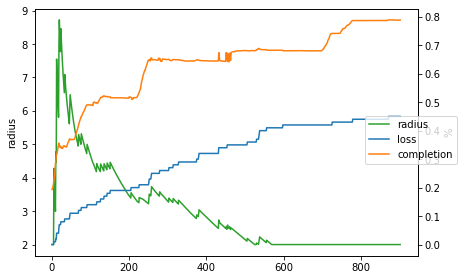

In [11]:
import time

# Display size
display_width = 1600
display_height = 800
SHOW = True

# Parameters
init_radius = 3
num_agents = 100
max_steps = 1000

# Adaptive model
w1 = 3
w2 = 2000
w3 = .005

# Start simulation
step = 0
t = []
w = World(100,100, num_agents, marker_size=init_radius, space_fill=0.5, hazard_fill=0.4)
model = AdaptiveModel(w, [w1, w2, w3])

start = time.time()
for i in range(max_steps):
    # Show frame if desired
    if SHOW:
        frame = w.render()
        shared_map = w.render(w.agents_map)
        frame = np.concatenate((frame, shared_map), axis=1)
        frame = cv2.resize(frame, (display_width, display_height), interpolation = cv2.INTER_AREA)
        cv2.imshow('Sim',cv2.cvtColor((frame*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Step simulation
    model.step()
    step += 1
    t.append(i)
    
    if (model.completion_history[-1] >= 0.9):
        break
    
end = time.time()
cv2.destroyAllWindows()
print(f"Average step time: {(end - start)/max_steps}")
print(f"Completion: {model.completion_history[-1]}, Loss: {model.loss_history[-1]}")

fig, ax1 = plt.subplots()

ax1.set_ylabel('radius')
ax1.plot(t, model.radius_history, color='tab:green', label="radius")
fig.tight_layout()

ax2 = ax1.twinx()
ax2.set_xlabel('time')
ax2.set_ylabel('%')
ax2.plot(t, model.loss_history, label="loss")
ax2.plot(t, model.completion_history, label="completion")
fig.legend(loc='center right');

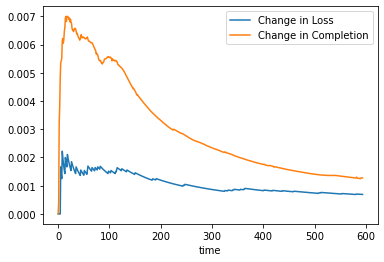

In [63]:
plt.plot(t, model.avgdloss_history, label="Change in Loss")
plt.plot(t, model.avgdcompletion_history, label="Change in Completion")
plt.xlabel('time')
plt.legend()

## Run Adaptive Model over 100 Maps

In [12]:
import random
from swarm_mapping.world import World

# Parameters
init_radius = 3
num_agents = 100
max_steps = 1000

# Adaptive model
w1 = 3
w2 = 2000
w3 = .005

loss_data = []
completion_data = []
radius_data = []

for seed in np.arange(1,101,1):
    print(f"Running simulation {seed}")
    random.seed(seed)
    
    w = World(100, 100, 100, space_fill=0.5, hazard_fill=0.4, marker_size=3)
    model = AdaptiveModel(w, [w1, w2, w3])
    
    for i in range(max_steps):
        # Step simulation
        model.step()
        if (model.completion_history[-1] >= 0.9):
            break
    
    loss_data.append(model.loss_history)
    completion_data.append(model.completion_history)
    radius_data.append(model.radius_history)

Running simulation 1
Running simulation 2
Running simulation 3
Running simulation 4
Running simulation 5
Running simulation 6
Running simulation 7
Running simulation 8
Running simulation 9
Running simulation 10
Running simulation 11
Running simulation 12
Running simulation 13
Running simulation 14
Running simulation 15
Running simulation 16
Running simulation 17
Running simulation 18
Running simulation 19
Running simulation 20
Running simulation 21
Running simulation 22
Running simulation 23
Running simulation 24
Running simulation 25
Running simulation 26
Running simulation 27
Running simulation 28
Running simulation 29
Running simulation 30
Running simulation 31
Running simulation 32
Running simulation 33
Running simulation 34
Running simulation 35
Running simulation 36
Running simulation 37
Running simulation 38
Running simulation 39
Running simulation 40
Running simulation 41
Running simulation 42
Running simulation 43
Running simulation 44
Running simulation 45
Running simulation 

In [44]:
# Pad data
num_samples = 1000
for i in range(100):
    loss = loss_data[i]
    completion = completion_data[i]
    radius = radius_data[i]
    loss = np.pad(loss, (0, num_samples - len(loss)), 'constant', constant_values=loss[-1])
    completion = np.pad(completion, (0, num_samples - len(completion)), 'constant', constant_values=completion[-1])
    radius = np.pad(radius, (0, num_samples - len(radius)), 'constant', constant_values=radius[-1])
    loss_data[i] = loss
    completion_data[i] = completion
    radius_data[i] = radius
    
avg_losses = np.average(loss_data, 0)
avg_completions = np.average(completion_data, 0)
avg_radii = np.average(radius_data, 0)

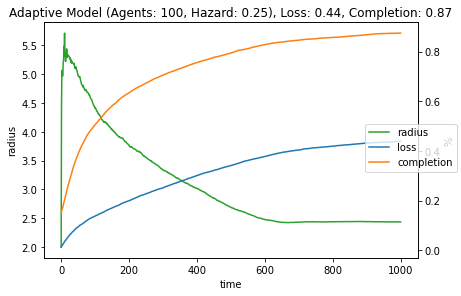

In [58]:
# Plot data
fig, ax1 = plt.subplots()

t = np.arange(0,1000,1)

ax1.set_xlabel('time')
ax1.set_ylabel('radius')
ax1.plot(t, avg_radii, color='tab:green', label="radius")
fig.tight_layout()

ax2 = ax1.twinx()
ax2.set_xlabel('time')
ax2.set_ylabel('%')
ax2.plot(t, avg_losses, label="loss")
ax2.plot(t, avg_completions, label="completion")
fig.legend(loc='center right');
plt.title(f"Adaptive Model (Agents: 100, Hazard: 0.25), Loss: {avg_losses[-1]:0.2f}, Completion: {avg_completions[-1]:0.2f}");